# Project 2 - Part 1

## TODO

- LSTM only predicts 1s

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import math
import torch.nn.functional as F
import torch.optim as optim
import tsfresh
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Exploratory Data Analysis

In [2]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns)-1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns)-1)] + ['label']
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

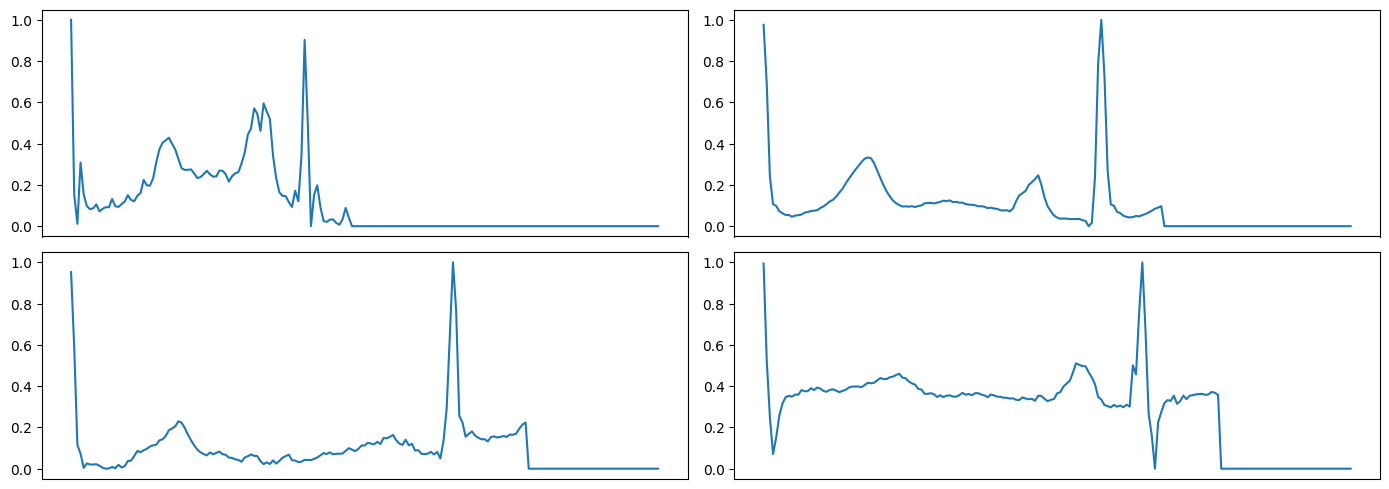

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5))

# Flatten the array for easy iteration
axs = axs.flatten()

# Iterate over the first 5 rows
for i in range(4):
    # Plot the data
    axs[i].plot(X_train.iloc[i, :])
    
    # Set x ticks in 3 equidistant positions
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

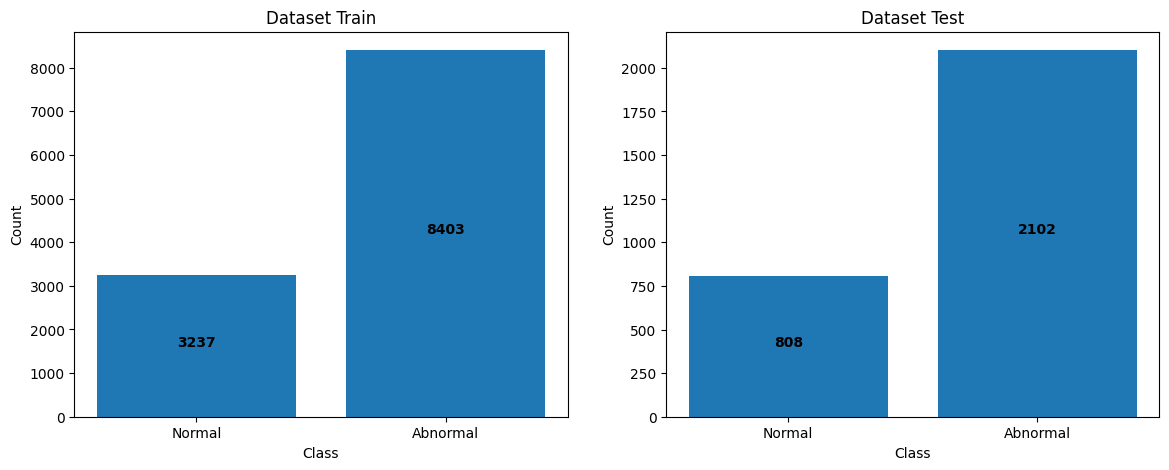

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(['Normal', 'Abnormal'], datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0]/2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1]/2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


In [5]:
n = len(y_train) + len(y_test)
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(len(datasets[i])/n*100) + '%')

Dataset Train: 80.0%
Dataset Test: 20.0%


In [6]:
for i in range(2):
    print('Dataset ' + dataset_names[i] + ': ' + str(np.mean(datasets[i])*100) + '%')

Dataset Train: 72.19072164948453%
Dataset Test: 72.23367697594502%


## Classic Machine Learning Methods

### Logistic Regression

In [8]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
print('Train accuracy: ' + str(log_reg.score(X_train, y_train)))
print('Test accuracy: ' + str(log_reg.score(X_test, y_test)))

Train accuracy: 0.8344501718213059
Test accuracy: 0.8223367697594501


### Random Forest

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Train accuracy: ' + str(rf.score(X_train, y_train)))
print('Test accuracy: ' + str(rf.score(X_test, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9670103092783505


### Feature Design

In [10]:
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

X_train_extended['mean'] = X_train.mean(axis=1)
X_train_extended['std'] = X_train.std(axis=1)
X_train_extended['median'] = X_train.median(axis=1)
X_train_extended['max'] = X_train.max(axis=1)
X_train_extended['min'] = X_train.min(axis=1)
X_train_extended['range'] = X_train.max(axis=1) - X_train.min(axis=1)
X_train_extended['iqr'] = X_train.quantile(0.75, axis=1) - X_train.quantile(0.25, axis=1)
X_train_extended['q1'] = X_train.quantile(0.25, axis=1)
X_train_extended['q3'] = X_train.quantile(0.75, axis=1)
X_train_extended['kurtosis'] = X_train.kurtosis(axis=1)
X_train_extended['skew'] = X_train.skew(axis=1)
X_test_extended['mean'] = X_test.mean(axis=1)
X_test_extended['std'] = X_test.std(axis=1)
X_test_extended['median'] = X_test.median(axis=1)
X_test_extended['max'] = X_test.max(axis=1)
X_test_extended['min'] = X_test.min(axis=1)
X_test_extended['range'] = X_test.max(axis=1) - X_test.min(axis=1)
X_test_extended['iqr'] = X_test.quantile(0.75, axis=1) - X_test.quantile(0.25, axis=1)
X_test_extended['q1'] = X_test.quantile(0.25, axis=1)
X_test_extended['q3'] = X_test.quantile(0.75, axis=1)
X_test_extended['kurtosis'] = X_test.kurtosis(axis=1)
X_test_extended['skew'] = X_test.skew(axis=1)

In [11]:
log_reg_extended = LogisticRegression(max_iter=1000)
log_reg_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(log_reg_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(log_reg_extended.score(X_test_extended, y_test)))

Train accuracy: 0.8384020618556701
Test accuracy: 0.8340206185567011


In [12]:
rf_extended = RandomForestClassifier()
rf_extended.fit(X_train_extended, y_train)
print('Train accuracy: ' + str(rf_extended.score(X_train_extended, y_train)))
print('Test accuracy: ' + str(rf_extended.score(X_test_extended, y_test)))

Train accuracy: 1.0
Test accuracy: 0.9714776632302405


## Recurrent Neural Networks - LSTM

In [212]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        
        _hidden_size = hidden_size if not bidirectional else hidden_size * 2
        self.fc = torch.nn.Linear(_hidden_size,output_size)
        self.sigmoid = nn.Sigmoid()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                # Initialize weights with Xavier initialization
                init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize biases to zeros
                init.constant_(param, 0.0)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [213]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [203]:
input_size = 1  
hidden_size = 10
output_size = 1

In [204]:
model = LSTMModel(input_size, hidden_size, output_size, bidirectional=True).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [205]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

In [222]:
model.init_weights()
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses_training.append(loss.item())
    
    with torch.no_grad():
        train_outputs = (outputs > 0.5).float()
        epoch_accuracies_training.append((train_outputs == y_train_tensor).cpu().float().mean())
    
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    epoch_losses_testing.append(loss_test.item())
    
    with torch.no_grad():
        test_outputs = (output_test > 0.5).float()
        epoch_accuracies_testing.append((test_outputs == y_test_tensor).cpu().float().mean())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.6887
Epoch [20/1000], Loss: 0.6797
Epoch [30/1000], Loss: 0.6700
Epoch [40/1000], Loss: 0.6604
Epoch [50/1000], Loss: 0.6510
Epoch [60/1000], Loss: 0.6418
Epoch [70/1000], Loss: 0.6328
Epoch [80/1000], Loss: 0.6242
Epoch [90/1000], Loss: 0.6163
Epoch [100/1000], Loss: 0.6094
Epoch [110/1000], Loss: 0.6036
Epoch [120/1000], Loss: 0.5992
Epoch [130/1000], Loss: 0.5960
Epoch [140/1000], Loss: 0.5939
Epoch [150/1000], Loss: 0.5926
Epoch [160/1000], Loss: 0.5918
Epoch [170/1000], Loss: 0.5915
Epoch [180/1000], Loss: 0.5913
Epoch [190/1000], Loss: 0.5912
Epoch [200/1000], Loss: 0.5912
Epoch [210/1000], Loss: 0.5911
Epoch [220/1000], Loss: 0.5911
Epoch [230/1000], Loss: 0.5911
Epoch [240/1000], Loss: 0.5911
Epoch [250/1000], Loss: 0.5911
Epoch [260/1000], Loss: 0.5911
Epoch [270/1000], Loss: 0.5911
Epoch [280/1000], Loss: 0.5911
Epoch [290/1000], Loss: 0.5911
Epoch [300/1000], Loss: 0.5911
Epoch [310/1000], Loss: 0.5911
Epoch [320/1000], Loss: 0.5911
Epoch [330/1000],

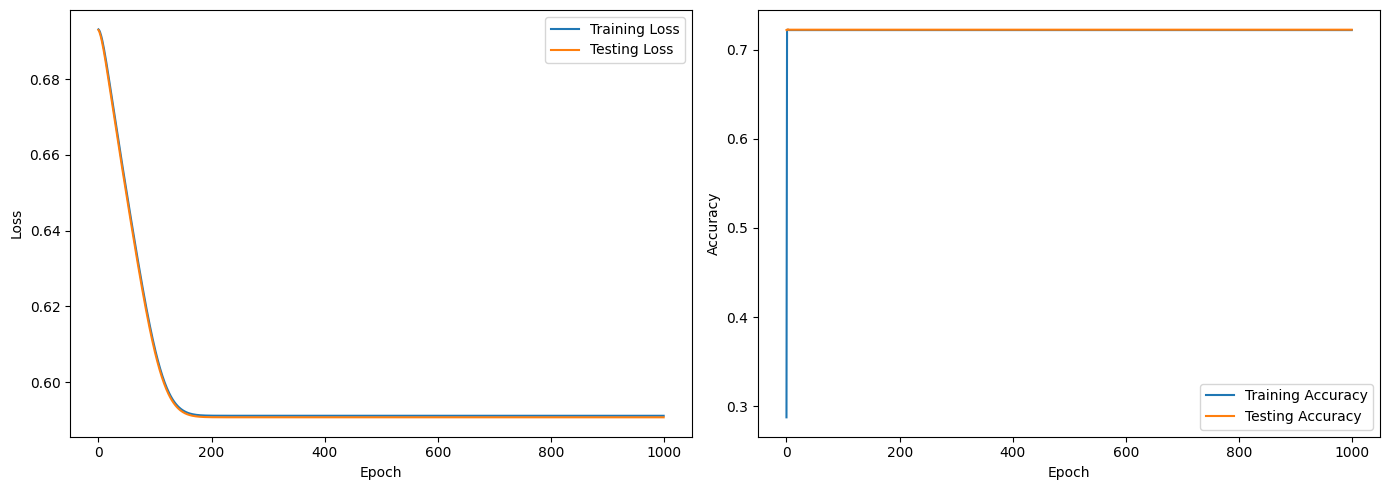

In [223]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

In [224]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')

tensor([[0.7219],
        [0.7219],
        [0.7219],
        ...,
        [0.7219],
        [0.7219],
        [0.7219]], device='mps:0')
Accuracy: 0.7223, Loss: 0.5907


In [231]:
for i in range(5):
    a = model(X_test_tensor[i, :, :].unsqueeze(0))
    print(a)

tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[0.7219]], device='mps:0', grad_fn=<SigmoidBackward0>)


## Convolutional Neural Networks

### Vanilla CNN

In [24]:
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32*input_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x[:, -1]

In [25]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [26]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [27]:
input_size = X_train_tensor.shape[1]
output_size = 1

In [28]:
model = CNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses_training.append(loss.item())
    
    with torch.no_grad():
        train_outputs = (outputs > 0.5).float()
        epoch_accuracies_training.append((train_outputs == y_train_tensor).cpu().float().mean())
    
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    epoch_losses_testing.append(loss_test.item())
    
    with torch.no_grad():
        test_outputs = (output_test > 0.5).float()
        epoch_accuracies_testing.append((test_outputs == y_test_tensor).cpu().float().mean())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.5773
Epoch [20/1000], Loss: 0.5503
Epoch [30/1000], Loss: 0.5198
Epoch [40/1000], Loss: 0.4885
Epoch [50/1000], Loss: 0.4645
Epoch [60/1000], Loss: 0.4432
Epoch [70/1000], Loss: 0.4260
Epoch [80/1000], Loss: 0.4123
Epoch [90/1000], Loss: 0.3998
Epoch [100/1000], Loss: 0.3895
Epoch [110/1000], Loss: 0.3803
Epoch [120/1000], Loss: 0.3717
Epoch [130/1000], Loss: 0.3637
Epoch [140/1000], Loss: 0.3565
Epoch [150/1000], Loss: 0.3503
Epoch [160/1000], Loss: 0.3444
Epoch [170/1000], Loss: 0.3392
Epoch [180/1000], Loss: 0.3345
Epoch [190/1000], Loss: 0.3298
Epoch [200/1000], Loss: 0.3255
Epoch [210/1000], Loss: 0.3217
Epoch [220/1000], Loss: 0.3180
Epoch [230/1000], Loss: 0.3147
Epoch [240/1000], Loss: 0.3113
Epoch [250/1000], Loss: 0.3082
Epoch [260/1000], Loss: 0.3048
Epoch [270/1000], Loss: 0.3021
Epoch [280/1000], Loss: 0.2990
Epoch [290/1000], Loss: 0.2962
Epoch [300/1000], Loss: 0.2932
Epoch [310/1000], Loss: 0.2912
Epoch [320/1000], Loss: 0.2873
Epoch [330/1000],

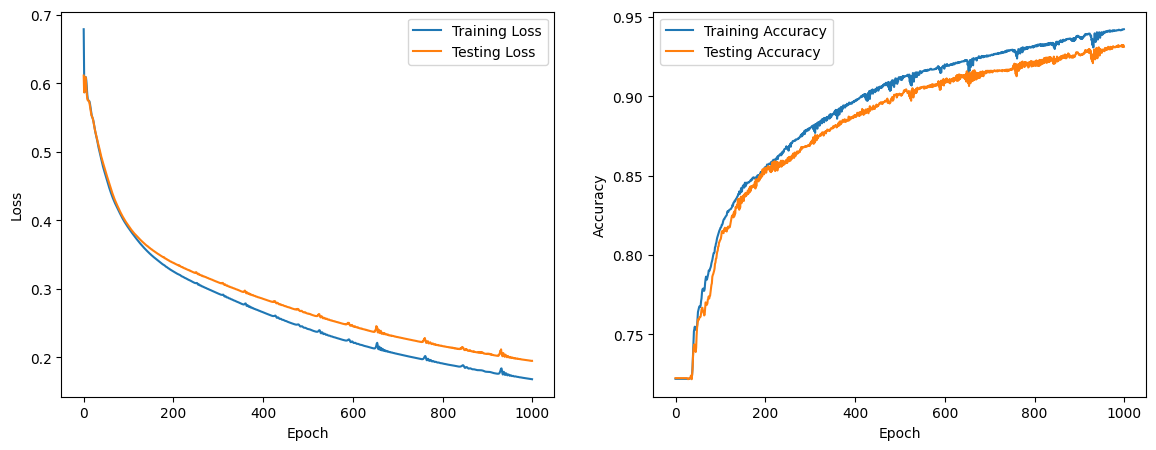

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

In [31]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')

Accuracy: 0.9313, Loss: 0.1948


### CNN with residual connections

In [32]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        x = self.relu(x)
        return x

In [33]:
class ResidualCNNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.residual_block1 = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2 = ResidualBlock(16, 16, 3, 1, 1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32*input_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x[:, -1]

In [34]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [35]:
input_size = X_train_tensor.shape[1]
output_size = 1

In [36]:
model = ResidualCNNModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses_training.append(loss.item())
    
    with torch.no_grad():
        train_outputs = (outputs > 0.5).float()
        epoch_accuracies_training.append((train_outputs == y_train_tensor).cpu().float().mean())
    
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    epoch_losses_testing.append(loss_test.item())
    
    with torch.no_grad():
        test_outputs = (output_test > 0.5).float()
        epoch_accuracies_testing.append((test_outputs == y_test_tensor).cpu().float().mean())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.5491
Epoch [20/1000], Loss: 0.5047
Epoch [30/1000], Loss: 0.4738
Epoch [40/1000], Loss: 0.4399
Epoch [50/1000], Loss: 0.4152
Epoch [60/1000], Loss: 0.4010
Epoch [70/1000], Loss: 0.3906
Epoch [80/1000], Loss: 0.3797
Epoch [90/1000], Loss: 0.3695
Epoch [100/1000], Loss: 0.3601
Epoch [110/1000], Loss: 0.3502
Epoch [120/1000], Loss: 0.3441
Epoch [130/1000], Loss: 0.3364
Epoch [140/1000], Loss: 0.3334
Epoch [150/1000], Loss: 0.3221
Epoch [160/1000], Loss: 0.3166
Epoch [170/1000], Loss: 0.3108
Epoch [180/1000], Loss: 0.3207
Epoch [190/1000], Loss: 0.3044
Epoch [200/1000], Loss: 0.2954
Epoch [210/1000], Loss: 0.2898
Epoch [220/1000], Loss: 0.2842
Epoch [230/1000], Loss: 0.2791
Epoch [240/1000], Loss: 0.2750
Epoch [250/1000], Loss: 0.2720
Epoch [260/1000], Loss: 0.2658
Epoch [270/1000], Loss: 0.2606
Epoch [280/1000], Loss: 0.2551
Epoch [290/1000], Loss: 0.2499
Epoch [300/1000], Loss: 0.2624
Epoch [310/1000], Loss: 0.2470
Epoch [320/1000], Loss: 0.2375
Epoch [330/1000],

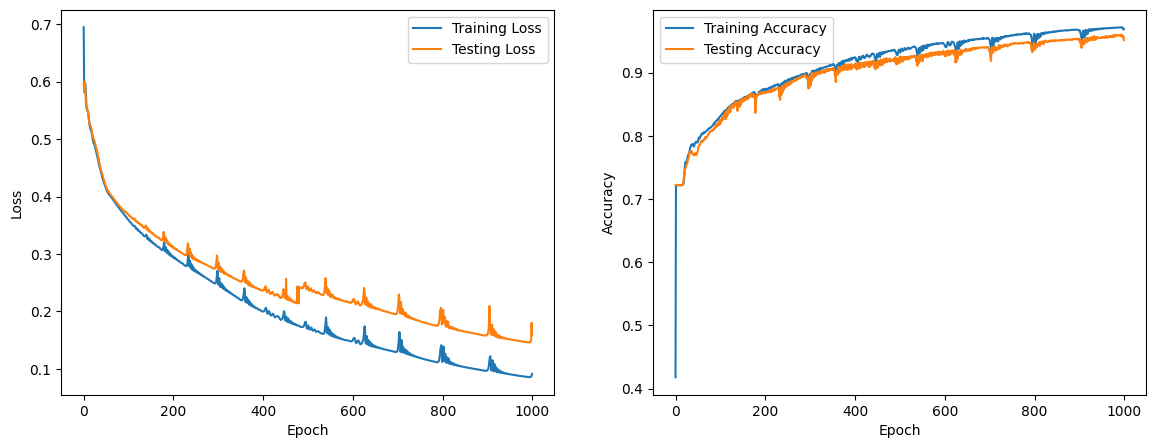

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

In [39]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')

Accuracy: 0.9515, Loss: 0.1587


## Attention and Transformers

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [16]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.sigmoid = nn.Sigmoid()
        self.d_model = d_model
        
    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.fc(output.mean(dim=1))  # Global average pooling
        output = self.sigmoid(output)
        return output

In [17]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [18]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [19]:
input_size = X_train_tensor.shape[1]
output_size = 1

In [20]:
model = TransformerModel(input_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
epoch_losses_training = []
epoch_losses_testing = []
epoch_accuracies_training = []
epoch_accuracies_testing = []

num_epochs = 10
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    epoch_losses_training.append(loss.item())
    
    with torch.no_grad():
        train_outputs = (outputs > 0.5).float()
        epoch_accuracies_training.append((train_outputs == y_train_tensor).cpu().float().mean())
    
    output_test = model(X_test_tensor)
    loss_test = criterion(output_test, y_test_tensor)
    epoch_losses_testing.append(loss_test.item())
    
    with torch.no_grad():
        test_outputs = (output_test > 0.5).float()
        epoch_accuracies_testing.append((test_outputs == y_test_tensor).cpu().float().mean())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: Invalid buffer size: 27.75 GB

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plotting the losses
axs[0].plot(epoch_losses_training, label='Training Loss')
axs[0].plot(epoch_losses_testing, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracies
axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
axs[1].plot(epoch_accuracies_testing, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

In [ ]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    outputs = (outputs > 0.5).float()
    accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}')